In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import spline
import numpy.polynomial.polynomial as poly
import scipy.stats as sct
import re
import networkx as nx
import operator
import matplotlib
%matplotlib inline

df_tran = pd.read_csv('../dataset/tran.txt',names=['primary-date','time','approximate-indicator','secondary-date','approximate-indicator',
  'transaction-ID','player','type','from-team','from-league','to-team','to-league','draft-type','draft-round','pick-number','info'])
df_playerid = pd.read_csv('../dataset/playerid_list.csv',names=['LASTNAME','FIRSTNAME','PLAYERID','DAVENPORTCODE','MLBCODE','player'],skiprows=1);
df_master = pd.read_csv('../dataset/Master.csv')
df_batstat = pd.read_csv('../dataset/war_daily_bat.txt')
df_pitchstat = pd.read_csv('../dataset/war_daily_pitch.txt')
df_cpi = pd.read_csv('../dataset/CPI.csv')
df_salaries = pd.read_csv('../dataset/Salaries.csv')
pd.set_option('display.max_columns', 60)

# Data Cleanup
# Recontructing invalid dates
df_tran['primary-date'] = df_tran['primary-date'].astype('str')
df_tran['primary-date'] = df_tran['primary-date'].str.replace(r'\A(\d{4})[0]{4}', r'\g<1>0101')
df_tran['primary-date'] = df_tran['primary-date'].str.replace(r'\A(\d{4})(..)[0]{2}', r'\g<1>\g<2>01')

#Extracting only trades from transaction dataframe
df_tran = df_tran[df_tran['type'] == "T "]
df_tran = df_tran[df_tran['to-league'].isin(['AL','NL'])]
df_tran = df_tran[df_tran['from-league'].isin(['AL','NL'])]

df_tran['primary-date'] = pd.to_datetime(df_tran['primary-date'], format='%Y%m%d')
df_tran['tranYear'] = df_tran['primary-date'].apply(lambda x : int(x.year))

dcash = df_tran['info'].str.replace(r' million', '000000') #replace million
dcash = dcash.str.replace(r'\D*\d*(\$\d*)\D*\d*', '\g<1>') #strip anything but $ followed by some digits
dcash = dcash.str.replace(r'\$$', '$0') #replace unknown cash as 0
df_tran['cash'] = dcash.str.replace(r'^((?!\$\d*).)*$', '') #replace anything that doen't contain a dollar with empty string

/home/piyush/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
G =nx.Graph()
for index, row in df_tran.iterrows():
    G.add_edge(row['from-team'] ,row['to-team']) 

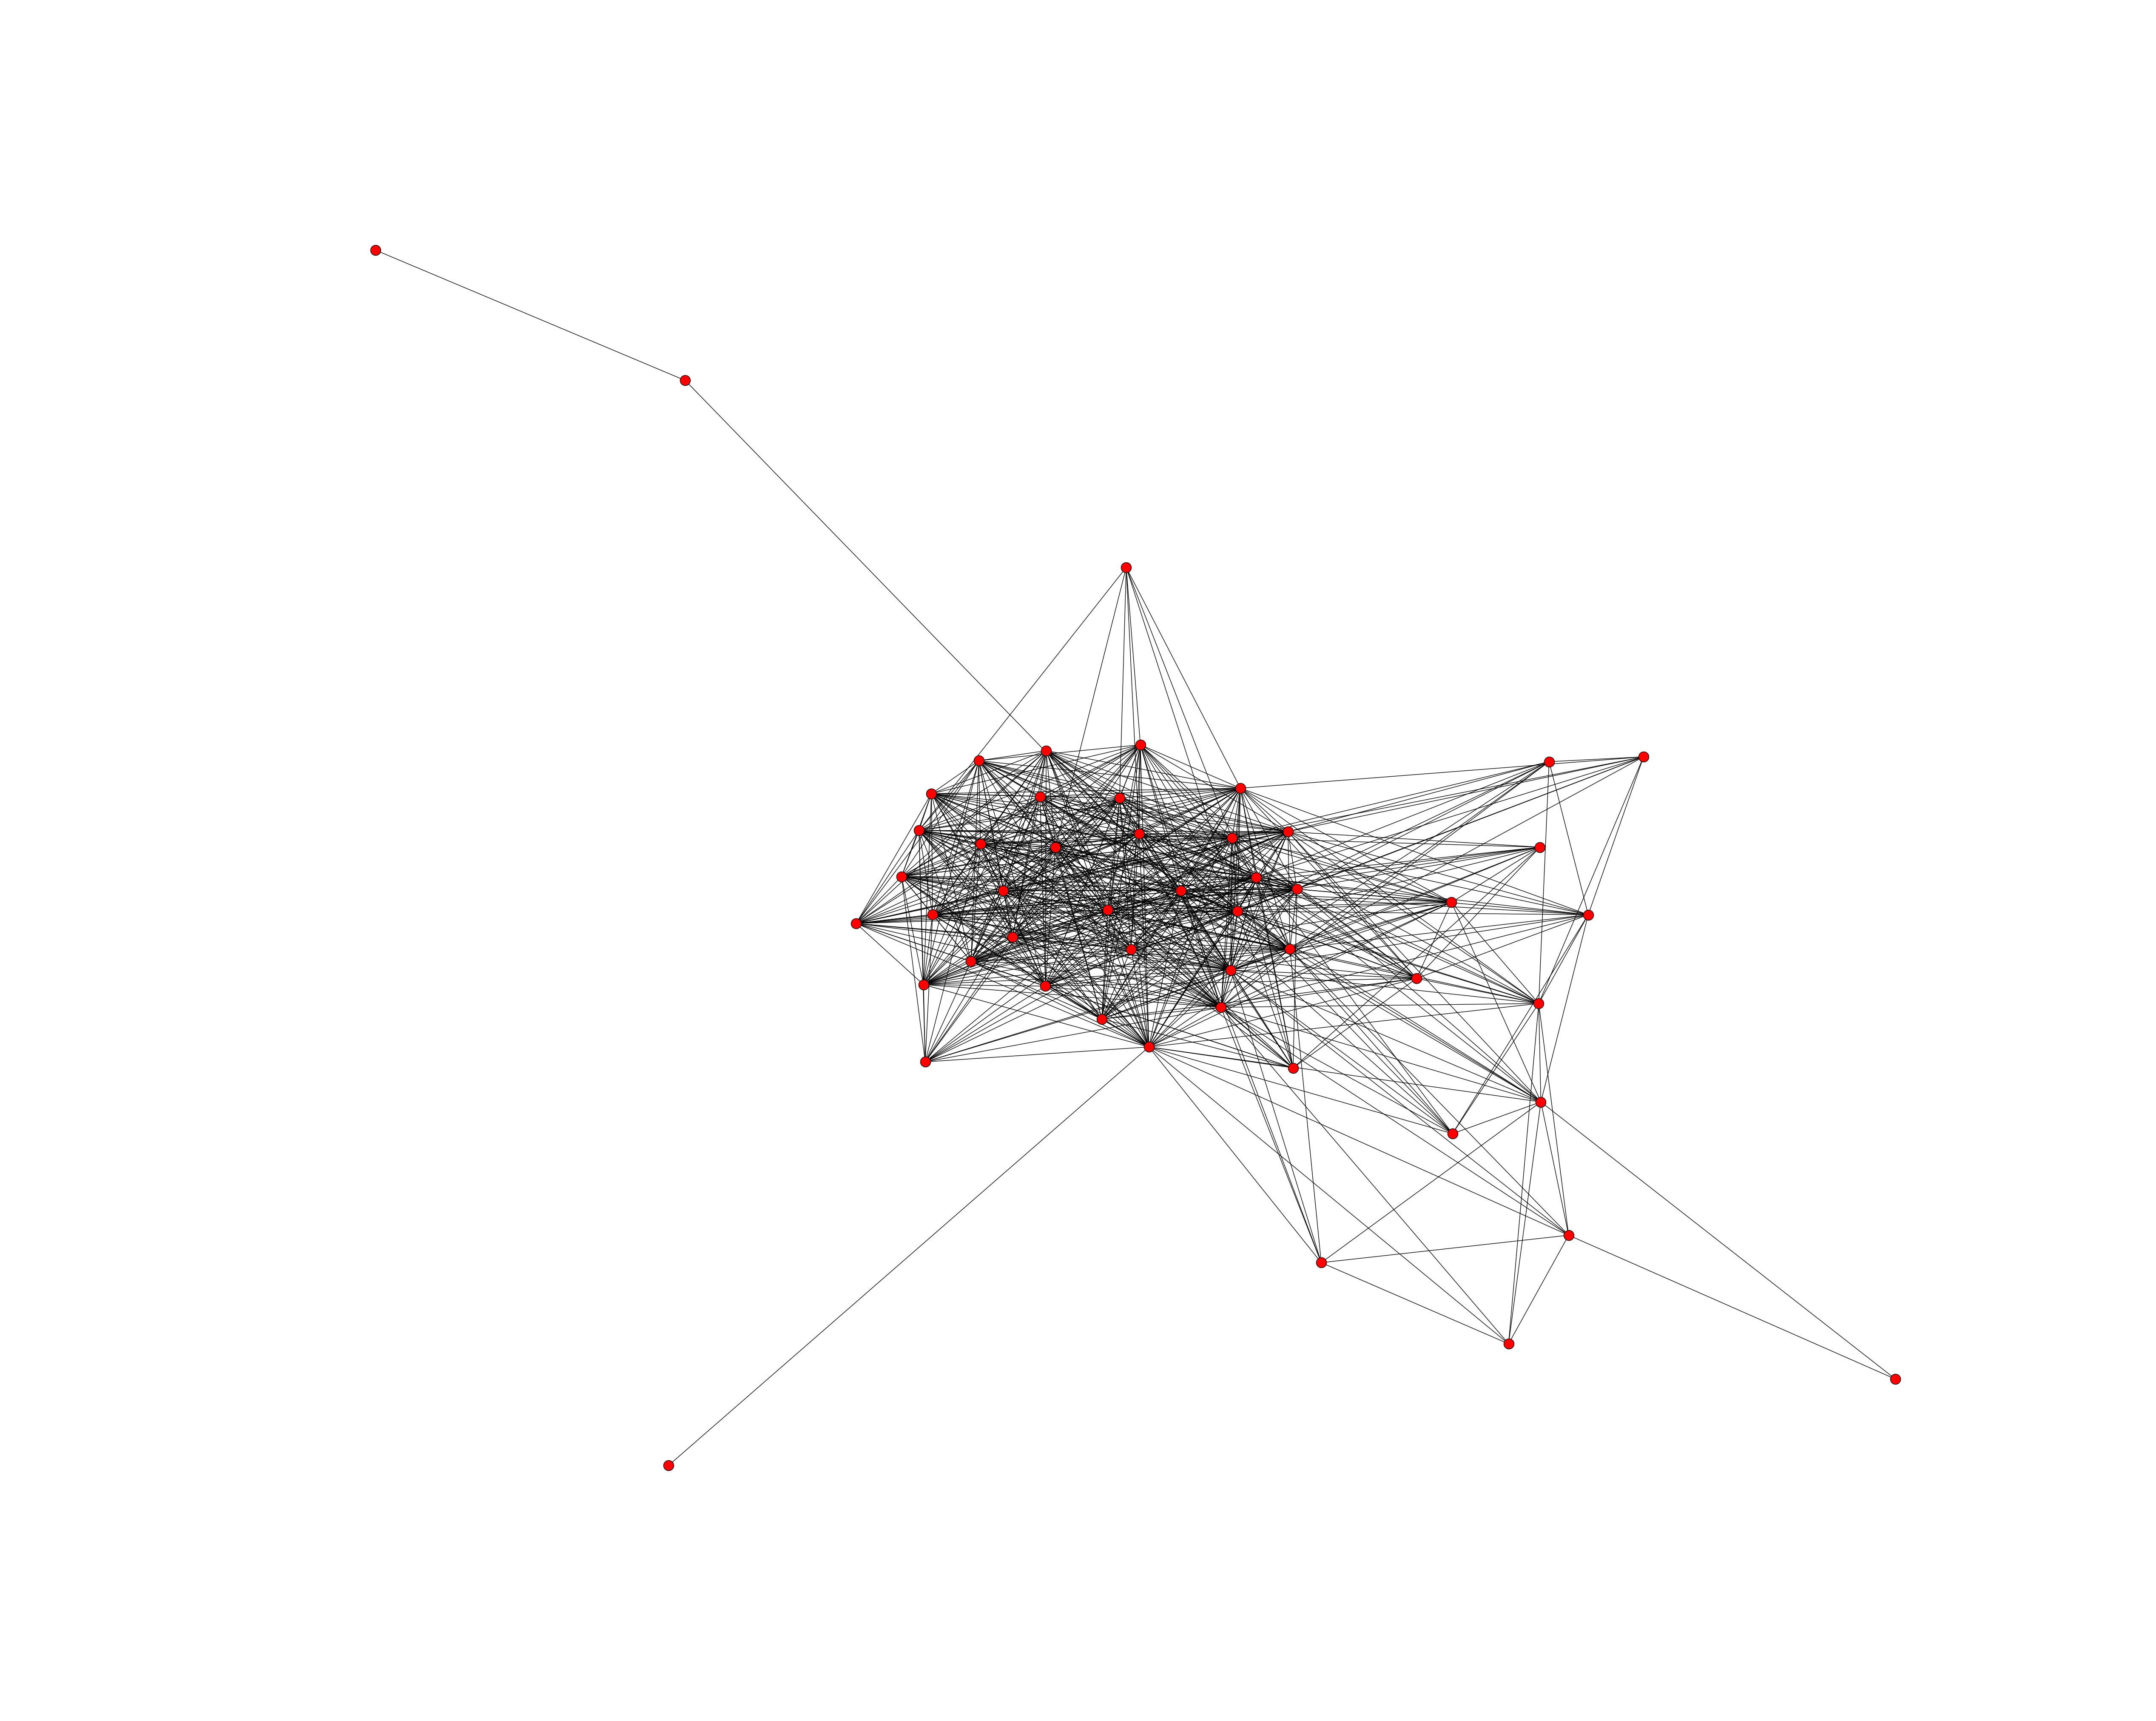

In [4]:
fig = plt.figure (figsize=(50,40))
nx.draw(G,pos=nx.spring_layout(G))
plt.savefig('graph.png')

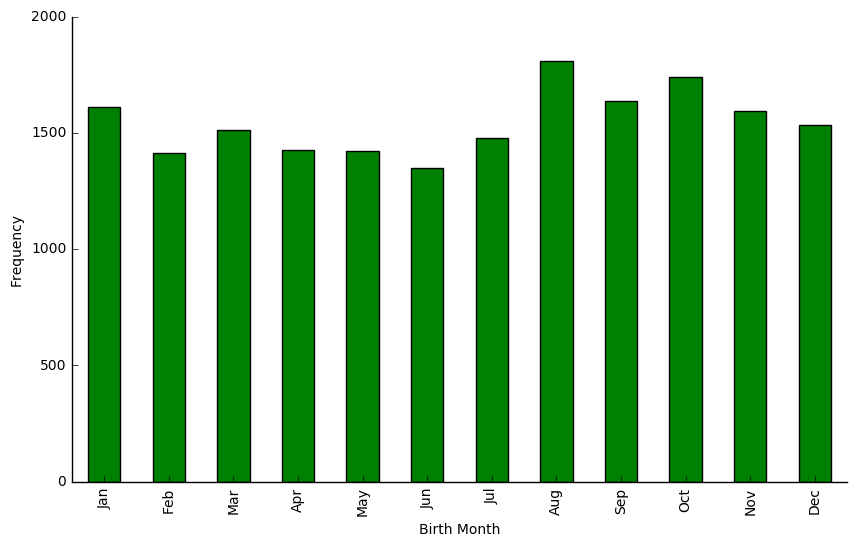

In [9]:
# Birthday Skew
fig = plt.figure(figsize=(10, 6))
 
ax = plt.subplot(111) 

ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()   
numBins = 50
x = df_master['birthMonth']
x = x.dropna()

plt.xlabel("Birth Month")
plt.ylabel("Frequency")

order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul','Aug','Sep','Oct','Nov','Dec']
x = x.apply(lambda x : order[int(x)-1])

# Draw the bar chart
x.value_counts().ix[order].plot(ax=ax, kind='bar',color='green')
plt.savefig('birth.png')
plt.show()

In [ ]:
# month where most transactions take place

df_ttime = df_tran['primary-date']
df_ttime = df_ttime.dropna()
df_ttime= df_ttime.apply(lambda x : x.strftime('%b'))

fig = plt.figure(figsize=(10, 6))
 
ax = plt.subplot(111) 

ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()   

plt.xlabel("Month")
plt.ylabel("Frequency")



order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul','Aug','Sep','Oct','Nov','Dec']

# Draw the bar chart
df_ttime.value_counts().ix[order].plot(ax=ax, kind='bar',color='#3F5D7D')
#ax.hist(df_ttime,numBins,color='green')
plt.savefig('trans.png')
plt.show()

In [41]:
# age at which player gets traded
df_master_year = df_master[['birthYear','retroID']]
df_master_year=  df_master_year.rename(columns = {'retroID':'player'})
df_master_year = df_master_year.dropna()
df_merged = pd.merge(df_tran,df_master_year,on='player',how='inner')
df_merged['Difference'] = df_merged['tranYear'].sub(df_merged['birthYear'], axis=0)

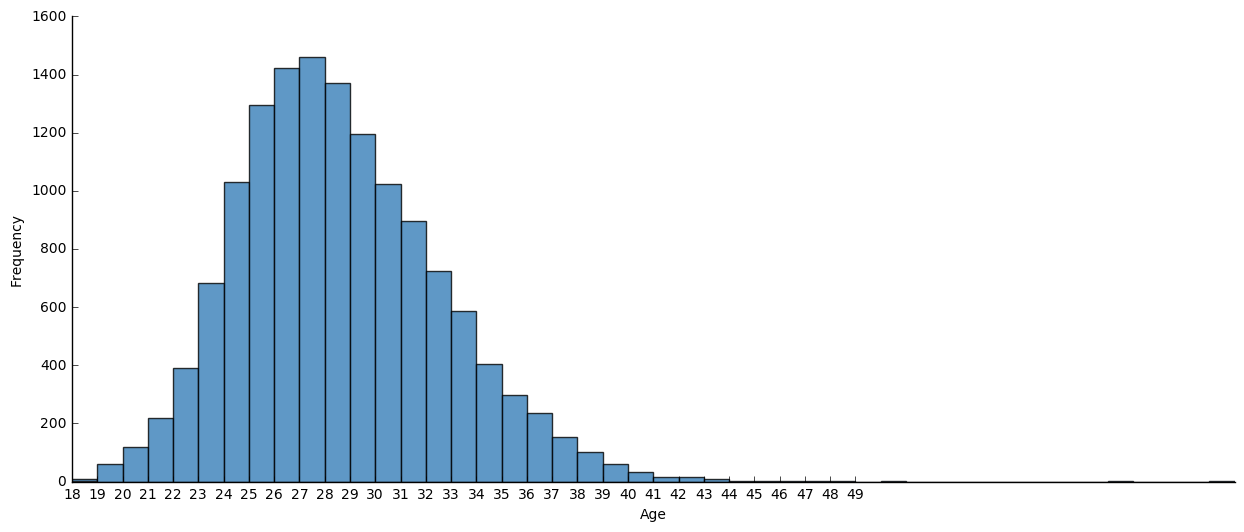

In [12]:
fig = plt.figure(figsize=(15, 6))
 
ax = plt.subplot(111) 

ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()   

x = df_merged['Difference']
x = x.dropna()
numBins = int(max(x) - min(x))
x = x.apply(lambda x : int(x))
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.xticks(range(0,50))
ax.hist(x,numBins,color='#377eb8',alpha=0.8)
plt.savefig('age.png')
plt.show()

In [13]:
# effect of experience on trade veterens vs prospects
df_master_dyear = df_master[['debut','retroID']]
df_master_dyear=df_master_dyear.rename(columns = {'retroID':'player'})
df_master_dyear = df_master_dyear.dropna()
df_master_dyear['debut'] = pd.to_datetime(df_master_dyear['debut'], format='%Y-%m-%d',errors = 'coerce')
df_master_dyear['debut'] = df_master_dyear['debut'].apply(lambda x : x.year)
df_merged = pd.merge(df_tran,df_master_dyear,on='player',how='inner')
df_merged['Difference'] = df_merged['tranYear'].sub(df_merged['debut'], axis=0)

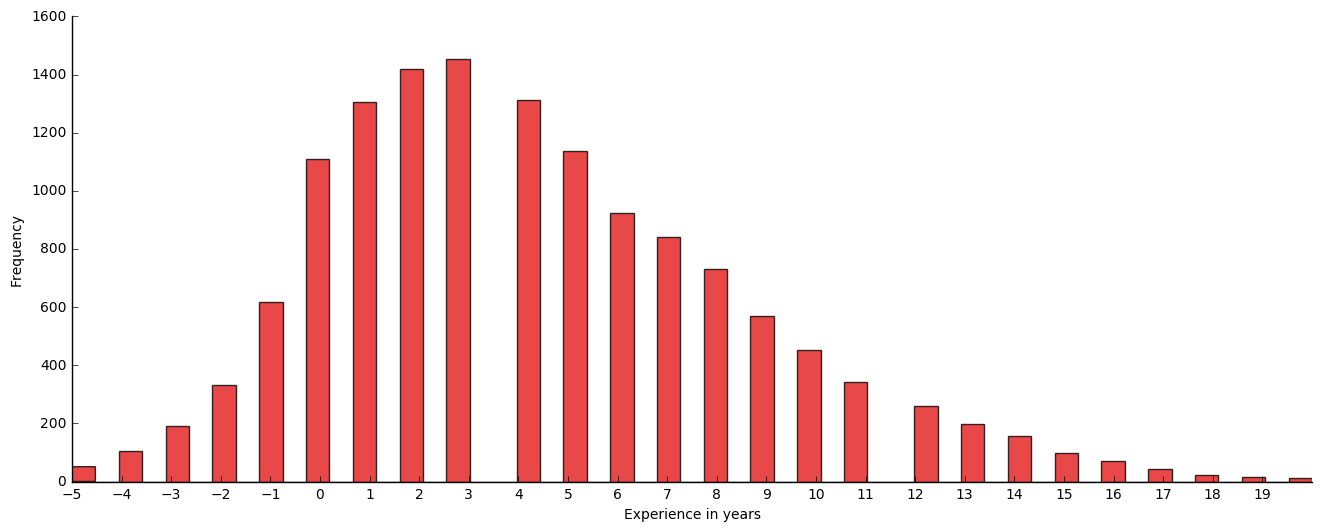

In [14]:
fig = plt.figure(figsize=(16, 6))
 
ax = plt.subplot(111) 

ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()   

x = df_merged['Difference']
x = x.dropna()
numBins = int(max(x) - min(x))
x = x.apply(lambda x : int(x))
plt.xlabel("Experience in years")
plt.ylabel("Frequency")
plt.xticks(range(-7,28))
ax.hist(x,numBins,color='#e41a1c',alpha=0.8, range=[-5, 20])
plt.savefig('exp.png')
plt.show()

Baseline Model

In [3]:
df_master['player_ID'] = df_master['bbrefID']
df_batstat = pd.merge(df_batstat,df_master[['player_ID','retroID']],on='player_ID',how='inner')
df_pitchstat = pd.merge(df_batstat,df_master[['player_ID','retroID']],on='player_ID',how='inner')

In [4]:
df_batstat.head()

,name_common,age,mlb_ID,player_ID,year_ID,team_ID,stint_ID,lg_ID,PA,G,Inn,runs_bat,runs_br,runs_dp,runs_field,runs_infield,runs_outfield,runs_catcher,runs_good_plays,runs_defense,runs_position,runs_position_p,runs_replacement,runs_above_rep,runs_above_avg,runs_above_avg_off,runs_above_avg_def,WAA,WAA_off,WAA_def,WAR,WAR_def,WAR_off,WAR_rep,salary,pitcher,teamRpG,oppRpG,oppRpPA_rep,oppRpG_rep,pyth_exponent,pyth_exponent_rep,waa_win_perc,waa_win_perc_off,waa_win_perc_def,waa_win_perc_rep,OPS_plus,TOB_lg,TB_lg,retroID
0,David Aardsma,22.0,430911.0,aardsda01,2004,SFG,1,NL,0,11,10.7,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.05,0.00,0.0,0.1,0.1,0.1,0.1,0.01,0.01,0.00,0.01,0.00,0.01,0.0,300000.0,Y,4.67546,4.67092,0.08651,4.67092,1.891,1.890,0.5005,0.5005,0.5005,0.5000,NaN,0.000,0.000,aardd001
1,David Aardsma,24.0,430911.0,aardsda01,2006,CHC,1,NL,3,45,53.0,-0.90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.21,0.46,0.0,-0.2,-0.2,-0.2,0.2,-0.02,-0.02,0.00,-0.02,0.00,-0.02,0.0,NaN,Y,4.86164,4.86675,0.09085,4.86467,1.912,1.913,0.4995,0.4995,0.5005,0.4998,-100.0,0.694,0.896,aardd001
2,David Aardsma,25.0,430911.0,aardsda01,2007,CHW,1,AL,0,25,32.3,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.11,0.00,0.0,0.1,0.1,0.1,0.1,0.01,0.01,0.02,0.01,0.02,0.01,0.0,387500.0,Y,4.86335,4.85895,0.08422,4.85895,1.912,1.912,0.5004,0.5004,0.5004,0.5000,NaN,0.000,0.000,aardd001
3,David Aardsma,26.0,430911.0,aardsda01,2008,BOS,1,AL,1,47,48.7,-0.29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.22,0.14,0.0,0.1,0.1,0.1,0.2,0.00,0.00,0.05,0.00,0.05,0.00,0.0,403250.0,Y,4.70549,4.70400,0.08092,4.70321,1.894,1.894,0.5001,0.5001,0.5005,0.4999,-100.0,0.345,0.434,aardd001
4,David Aardsma,27.0,430911.0,aardsda01,2009,SEA,1,AL,0,73,71.3,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.32,0.00,0.0,0.3,0.3,0.3,0.3,0.03,0.03,0.06,0.03,0.06,0.03,0.0,419000.0,Y,4.80227,4.79788,0.08302,4.79788,1.905,1.905,0.5004,0.5004,0.5004,0.5000,NaN,0.000,0.000,aardd001


In [5]:
df_batstat_sort = df_batstat.sort('age')
df_batstat_sort = df_batstat_sort[pd.notnull(df_batstat_sort['age'])]
agedict = {}

#print df_batstat_sort.age
for index, row in df_batstat_sort.iterrows():
    if(row['age'] in agedict):
        agedict[row['age']].append(row['WAR'])
    else:
        agedict[row['age']] = [row['WAR']]

/home/piyush/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [6]:
age = []
avg_WAR= []
i=0
for key in agedict:
    if (~np.isnan(key)):
        avg = np.nansum(agedict[key]) / float(len(agedict[key]))
        age.append(key)
        avg_WAR.append(avg)
        
age_df = pd.DataFrame({ 'Age' : age,'Average_WAR' : avg_WAR}).sort('Age')

/home/piyush/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [7]:
#age_df
def getAvgWarForAge(age):
    return (age_df[(age_df['Age'] == age)]['Average_WAR']).iloc[0]

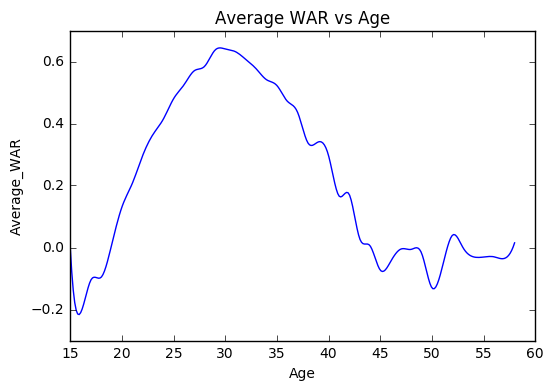

In [12]:
plt.xlabel("Age")
plt.ylabel("Average_WAR")
plt.title("Average WAR vs Age")
#plt.plot(age_df.Age, age_df.Average_WAR);

from scipy.interpolate import spline
xnew = np.linspace(min(age_df.Age),max(age_df.Age),300)
power_smooth = spline(age_df.Age,age_df.Average_WAR,xnew)
plt.plot(xnew,power_smooth)
plt.savefig("avg_war.png")

In [46]:
#Calculates the absolute difference between two sides of a trade by summing the WAR values of each player on each side for 
#the year in which the trade took place
def trade_value_old(tranID,metric):
    td = df_tran[(df_tran['transaction-ID'] == tranID)]
    teams = td['from-team'].unique()
    val = 0
    player_vals = []
    for x in teams:
        val = 0
        for index, row in td.iterrows():
            #val = 0
            if (row['from-team'] == x):
                if pd.isnull(row['player']):
                    # filter out cash transactions or yet to be named player transaction 
                    continue
                player_df = df_batstat[(df_batstat['retroID'] == row['player'])]
                player_df_year = player_df[(df_batstat['year_ID'] == row['tranYear'])]
                if not player_df_year.empty:
                    val += float(player_df_year[metric].iloc[0])
                elif not player_df.empty:
                    # take a random value if we don't have war for that transaction year, put logic to change this to nearest year
                    val += float(player_df['WAR'].iloc[0])
                else:
                    ## figure out a way to find war for these players
                    val += 0
        player_vals.append(val)
    return (abs(player_vals[0]-player_vals[1]),tranID)

In [48]:
#Calculates the absolute difference between two sides of a trade by summing the WAR values of each player on each side one
# year after the trade took place
def trade_value(tranID,metric):
    td = df_tran[(df_tran['transaction-ID'] == tranID)]
    teams = td['from-team'].unique()
    val = 0
    player_vals = []
    for x in teams:
        val = 0
        for index, row in td.iterrows():
            #val = 0
            if (row['from-team'] == x):
                if pd.isnull(row['player']):
                    # filter out cash transactions or yet to be named player transaction
                    continue
                player_df = df_batstat[(df_batstat['retroID'] == row['player'])]
                player_df_year = player_df[(df_batstat['year_ID'] == row['tranYear'])]
                #instead need a df for the player after the trans year, and not just next, but all consecutive years
                for i in range(15):
                    player_df_year_next = player_df[(df_batstat['year_ID'] == (row['tranYear'] + i))]
                    if not player_df_year_next.empty:
                        # get the value of metric for each year after trade until 15 years else assume 0
                        val += float(player_df_year_next[metric].iloc[0]) - getAvgWarForAge(player_df_year_next['age'].iloc[0])
                    else:
                        ## figure out a way to find war for these players
                        val += 0
        player_vals.append(val)
    return (abs(player_vals[0]-player_vals[1]),tranID)

In [49]:
#Calculating the trade value difference for each transaction using metric WAR,WAA,PA,Salary & TA
trade_val_list_WAR = []
transactions = df_tran['transaction-ID'].unique()
for x in transactions:
    trade_val_list_WAR.append(trade_value(x,'WAR'))

/home/piyush/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/piyush/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


<function matplotlib.pyplot.show>

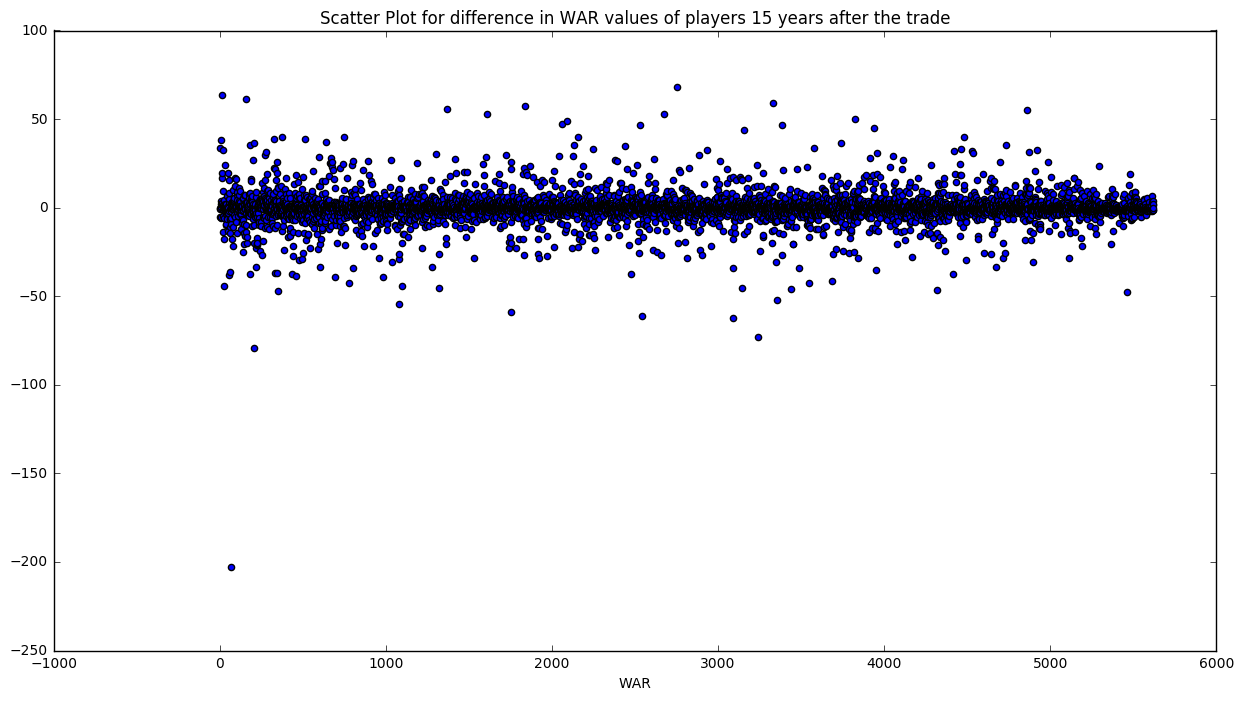

In [52]:
#trade_val_list
new_trade_val_list_WAR =[]
for i in trade_val_list_WAR:
    new_trade_val_list_WAR.append(i[0])

# Scatter plot for Wins Above Replacement
x_pos = np.arange(0,len(new_trade_val_list_WAR))
plt.figure(figsize=(15, 8))
plt.title("Scatter Plot for difference in WAR values of players 15 years after the trade")
plt.xlabel("WAR")
plt.scatter(x_pos, new_trade_val_list_WAR)
plt.show

In [47]:
trade_val_list_WAR_old = []
transactions = df_tran['transaction-ID'].unique()
for x in transactions:
    trade_val_list_WAR_old.append(trade_value_old(x,'WAR'))

/home/piyush/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [58]:
# transaction for the second worst deal in the above list
#df_tran[df_tran['transaction-ID'] == 51700]
td = df_tran[(df_tran['transaction-ID'] == 51700)]
teams = td['from-team'].unique()
print teams
td
trade_value(51700,'WAR')

['OAK' 'NYA']


/home/piyush/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/piyush/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


(-45.520810752427842, 51700)

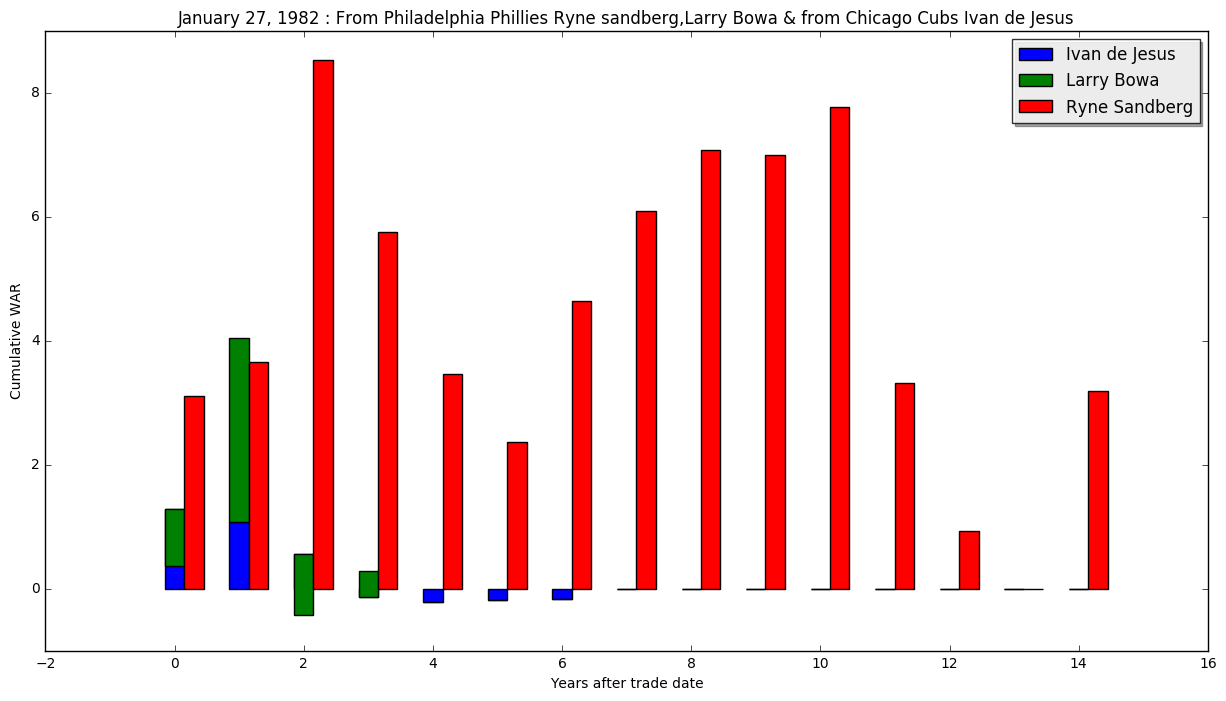

In [59]:
#Trade Analysis for a particulat trade
y = [1.28,1.08,0.55,-0.14,-0.22,-0.18,-0.17,0,0,0,0,0,0,0,0]
z = [-0.91,2.96,-0.97,0.43,0,0,0,0,0,0,0,0,0,0,0]
k = [3.11,3.66,8.52,5.75,3.46,2.36,4.63,6.09,7.07,7.00,7.76,3.32,0.93,0,3.19]
#x1 = ["1982","1983","1984","1985","1986","1987","1988","1989","1990","1991","1992","1993","1994","1995","1996"]
x1 = [1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996]
x = np.arange(len(y))

plt.figure(figsize=(15, 8))
plt.title("January 27, 1982 : From Philadelphia Phillies Ryne sandberg,Larry Bowa & from Chicago Cubs Ivan de Jesus")
plt.xlabel("Years after trade date")
plt.ylabel("Cumulative WAR")
#plt.xticks(x1)
ax = plt.subplot(111)
ax.bar(x, y,width=0.3,color='b',align='center')
ax.bar(x, z,width=0.3,color='g',align='center', bottom=y)
ax.bar(x+0.3, k,width=0.3,color='r',align='center')
ax.legend(loc="upper right",frameon = True,framealpha=0.8,shadow=True,
           labels=("Ivan de Jesus","Larry Bowa","Ryne Sandberg"))
plt.show()

In [16]:
#Calculates the absolute difference between two sides of a trade by summing the WAR values of each player on each side one
# year after the trade took place
def trade_value_mod(tranID,metric):
    td = df_tran[(df_tran['transaction-ID'] == tranID)]
    year = td['tranYear'].iloc[0]
    teams = td['from-team'].unique()
    val = 0
    player_vals = []
    for x in teams:
        val = 0
        for index, row in td.iterrows():
            #val = 0
            if (row['from-team'] == x):
                if pd.isnull(row['player']):
                    # filter out cash transactions or yet to be named player transaction
                    continue
                player_df = df_batstat[(df_batstat['retroID'] == row['player'])]
                player_df_year = player_df[(df_batstat['year_ID'] == row['tranYear'])]
                #instead need a df for the player after the trans year, and not just next, but all consecutive years
                for i in range(15):
                    player_df_year_next = player_df[(df_batstat['year_ID'] == (row['tranYear'] + i))]
                    if not player_df_year_next.empty:
                        # get the value of metric for each year after trade until 15 years else assume 0
                        val += float(player_df_year_next[metric].iloc[0]) - getAvgWarForAge(player_df_year_next['age'].iloc[0])
                    else:
                        ## figure out a way to find war for these players
                        val += 0
        player_vals.append(val)
    return (abs(player_vals[1]-player_vals[0]),tranID,year)

In [17]:
#Calculating the trade value difference for each transaction using metric WAR,WAA,PA,Salary & TA
trade_val_list_WAR_mod = []
transactions = df_tran['transaction-ID'].unique()
for x in transactions:
    trade_val_list_WAR_mod.append(trade_value_mod(x,'WAR'))

/home/piyush/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/piyush/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [19]:
temp_df = pd.DataFrame(trade_val_list_WAR_mod, columns=["WAR_Diff","TranID","TranYear"])
years = temp_df['TranYear'].unique()
years = sorted(years)
means = []
medians = []
maxs = []
for i in years:
    yd = temp_df[(temp_df['TranYear'] == i)]
    means.append(yd["WAR_Diff"].mean())
    maxs.append(yd["WAR_Diff"].max())
    medians.append(yd["WAR_Diff"].median())

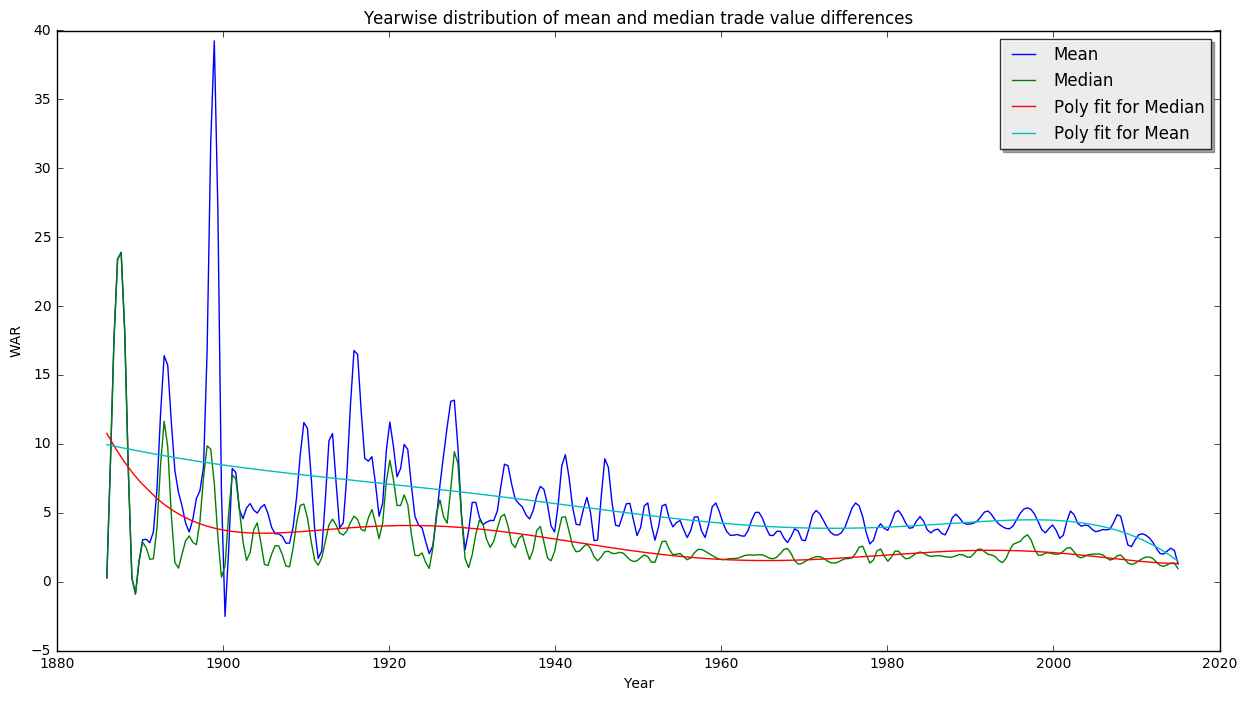

In [35]:
plt.figure(figsize=(15, 8))
plt.title("Yearwise distribution of mean and median trade value differences")
plt.xlabel("Year")
plt.ylabel("WAR")
#plt.plot(years, means);
#plt.plot(years, medians,color='g');
plt.legend(loc="upper right",frameon = True,framealpha=0.8,shadow=True,
           labels=("Mean","Median"))
#plt.plot(years, maxs,color='r');

xnew = np.linspace(min(years),max(years),300)
power_smooth = spline(years,means,xnew)
plt.plot(xnew,power_smooth)

power_smooth = spline(years,medians,xnew)
plt.plot(xnew,power_smooth)

coefs = poly.polyfit(years, medians, 7)
ffit = poly.polyval(years, coefs)
plt.plot(years, ffit)

coefs = poly.polyfit(years, means, 7)
ffit = poly.polyval(years, coefs)
plt.plot(years, ffit)
plt.legend(loc="upper right",frameon = True,framealpha=0.8,shadow=True,
           labels=("Mean", "Median", "Poly fit for Median", "Poly fit for Mean"))

plt.savefig("mean-median.png")

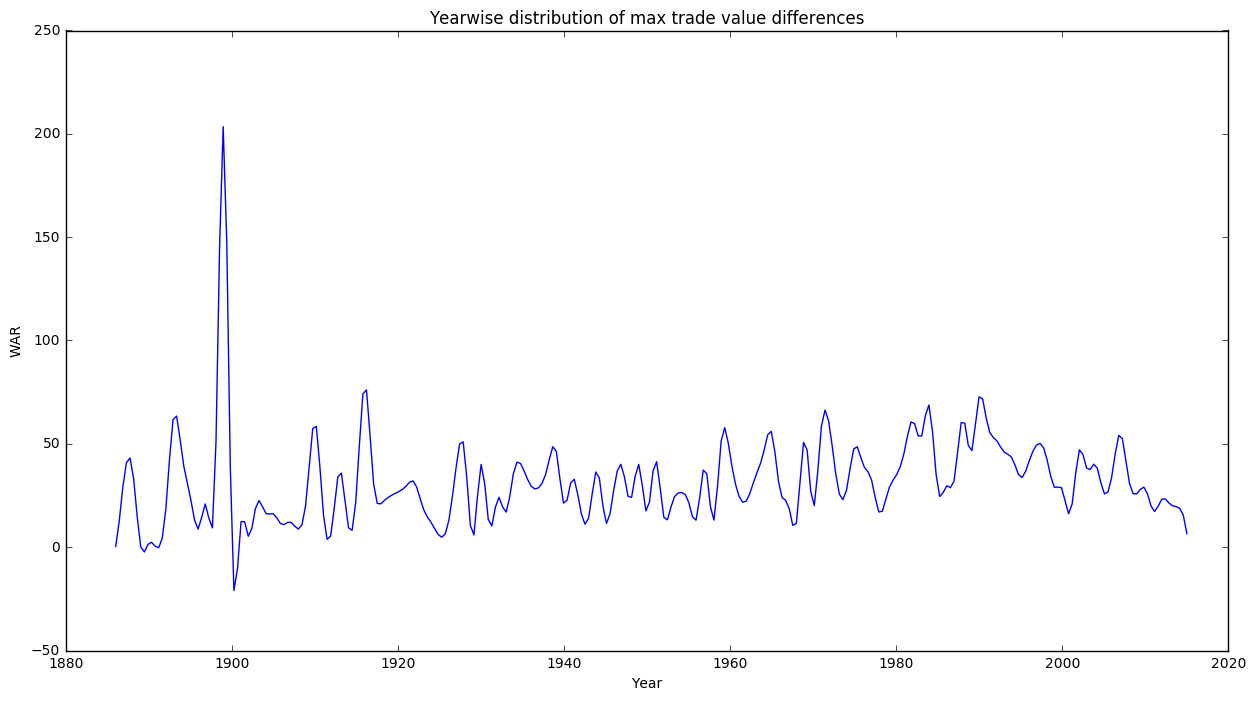

In [21]:
plt.figure(figsize=(15, 8))
plt.title("Yearwise distribution of max trade value differences")
plt.xlabel("Year")
plt.ylabel("WAR")
#plt.plot(years, maxs,color='r');

xnew = np.linspace(min(years),max(years),300)
power_smooth = spline(years,maxs,xnew)
plt.plot(xnew,power_smooth)
plt.show()

In [68]:
val_list_1 = pd.DataFrame(trade_val_list_WAR, columns=["WAR_Diff","TranID"])
val_list_2 = pd.DataFrame(trade_val_list_WAR_old, columns=["WAR_Diff","TranID"])
sorted_val_list_1 = val_list_1.sort(["TranID"], ascending=[False])
sorted_val_list_2 = val_list_2.sort(["TranID"], ascending=[False])

/home/piyush/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()
/home/piyush/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [70]:
t_sorted_val_list_1 = val_list_1.sort(["WAR_Diff"], ascending=[False])
t_sorted_val_list_1[:20]

/home/piyush/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,WAR_Diff,TranID
66,203.135364,48301
204,79.202935,65088
3243,73.083466,51801
2753,68.163469,51311
15,63.858807,48235
3090,62.525871,51648
2544,61.391467,51102
158,61.076799,48448
3332,59.053398,51890
1750,58.872620,50308


Mean Square Error: 6.52680325465


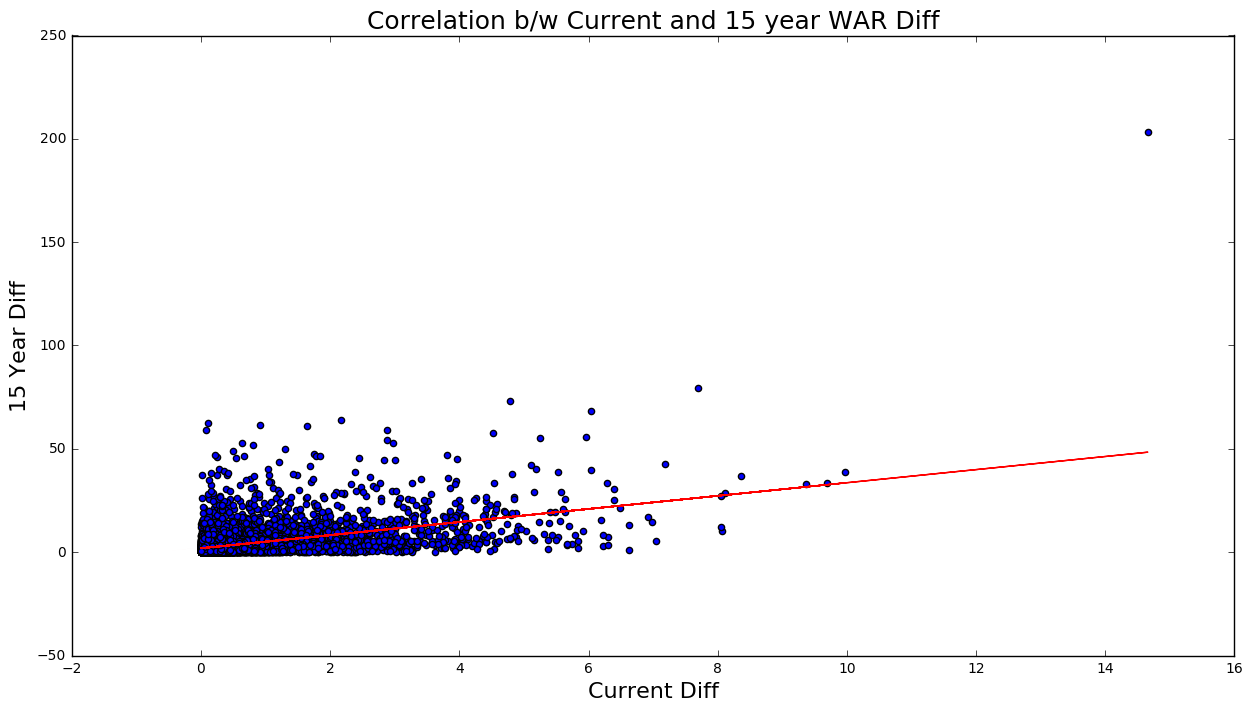

In [54]:
#Linear Regression Model
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing

(a,b) = np.polyfit(sorted_val_list_2["WAR_Diff"], sorted_val_list_1["WAR_Diff"], deg=1)
err =  np.sqrt(mean_squared_error(np.polyval([a,b], sorted_val_list_2["WAR_Diff"]), sorted_val_list_1["WAR_Diff"]))
print "Mean Square Error:", err

plt.figure(figsize=(15, 8))
plt.xlabel('Current Diff', {'fontsize':16})
plt.ylabel('15 Year Diff', {'fontsize':16})
plt.title('Correlation b/w Current and 15 year WAR Diff', {'fontsize':18})
plt.plot(sorted_val_list_2["WAR_Diff"], a * sorted_val_list_2["WAR_Diff"] + b, color='red')
plt.scatter(sorted_val_list_2["WAR_Diff"], sorted_val_list_1["WAR_Diff"])
plt.savefig("baseline.png")

In [55]:
#Correlation Coefficent
value = sct.pearsonr(sorted_val_list_1["WAR_Diff"],sorted_val_list_2["WAR_Diff"])
#coeff_list.append((value[0], value[1], x, y))
print "Correlation Coefficient:",value[0]
print "Correlation p-Value:",value[1]

Correlation Coefficient: 0.469736332344
Correlation p-Value: 1.3179029177e-306


In [76]:
#Accuracy measurement
sorted_val_list_1_list = sorted_val_list_1.values.tolist()
sorted_val_list_2_list = sorted_val_list_2.values.tolist()
matches = 0
#Check if predictions are matching (just sign comparisons, this denotes which side got a better deal)
for i in range(len(sorted_val_list_1_list)):
    if((sorted_val_list_1_list[i][0] > 0 and sorted_val_list_2_list[i][0] > 0) or
      (sorted_val_list_1_list[i][0] < 0 and sorted_val_list_2_list[i][0] < 0)):
        matches += 1

accuracy = float(matches)/len(sorted_val_list_1_list)
#print "Accuracy: ",accuracy

In [ ]:
#Taking 2016 CPI as current
curr_cpi = df_cpi[df_cpi['Year']==2016]['CPI'].iloc[0]

#Calculating the value of each cash tran as per CPI to 2016 value
#When incorrect values obeserved, making the new val as -1
new_cash_val = []
for index, row in df_tran.iterrows():
    if not((pd.isnull(row['cash'])) ):
        t1 = row['cash']
        t1 = re.sub('[$]', '', t1)
        old_cpi_df = df_cpi[df_cpi['Year']== row['tranYear']]['CPI']
        old_cpi = old_cpi_df.iloc[0]
        #print t1,old_cpi
        try:
            new_val = float((curr_cpi/old_cpi))*float(t1)
            #print new_val
            new_cash_val.append(new_val)
        except ValueError,e:
            print "error",e,"on row",row['cash']
            new_cash_val.append(-1)
    else:
        new_cash_val.append(-1)

#Finally adding the calculated values as a new column in df_tran without the $ sign
df_tran['cash_curr'] = new_cash_val
#df_tran['cash_curr']

In [ ]:
#adjusting salaries based  on inflation
curr_cpi = df_cpi[df_cpi['Year']==2016]['CPI'].iloc[0]
#print curr_cpi
#Calculating the value of each sallaries as per CPI to 2016 value
salary_per_yr = []
war=[]
for index, row in df_salaries.iterrows():
    if not((pd.isnull(row['salary'])) ):
        t1 = row['salary']
        old_cpi_df = df_cpi[df_cpi['Year']== row['yearID']]['CPI']
        player_war = df_batstat[(df_batstat['year_ID']==row['yearID']) & (df_batstat['player_ID']==row['playerID'])]['WAR']
        if (player_war.empty):
            #print 'values is null'
            player_war = df_pitchstat[(df_pitchstat['year_ID']==row['yearID']) & (df_pitchstat['player_ID']==row['playerID'])]['WAR']
        if (player_war.empty):
            war.append(0)
        else:
            war.append(player_war.values[0])
        old_cpi = old_cpi_df.iloc[0]
        #print t1,old_cpi
        try:
            new_val = float((curr_cpi/old_cpi))*float(t1)
            #print 'printing',new_val
            salary_per_yr.append(new_val)
        except ValueError,e:
            #print "error",e,"on row",row['cash']
            salary_per_yr.append(0)
    else:
        war.append(0)
        salary_per_yr.append(0)

In [65]:
df_salaries['Salary_curr'] = salary_per_yr
df_salaries['WAR'] = war
# calculating average salary and war
average_salary = np.nansum(salary_per_yr) / float(len(salary_per_yr))
average_war = np.nansum(war) / float(len(war))
print "Average Salary: ",average_salary
print "Average WAR: ", average_war
print "1 WAR = $",average_salary/average_war

Average Salary:  2514082.95989
Average WAR:  0.639999608993
1 WAR = $ 3928257.02479
